### TODO

* <s>change 'data_y' to 'response'.</s>
* <s>change generate response so that it adds the response to the dataset.</s>
* change methods that use a data_y input to potentially extract from the dataset.... (in some cases)
    use data_y = feature_dict(data)[last feature] or data[-1] etc.
* delete some old code.
* after cleaning/testing code, pull out methods into separate demo_methods.py file, and create demo.py file and demo.ipynb files to illustrate use, interpretation, and workflow.

In [189]:
# import libraries
import matplotlib.pyplot as plt
from matplotlib import pylab
import math
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import sklearn.linear_model

In [190]:
# generate data
def generate_data(sample_size=500, number_of_features=6, dist_type = 'uniform', mean=456, sd=45):
    """
    number_of_features = int
    sample_size = int
    dist_type = string
    
    optional args for specifying distributions:
        mean
        sd
        
    returns a numpy dataframe 'data'
    """
    
    if dist_type == 'uniform':
        val_range = list(range(math.ceil(2.5*sample_size*number_of_features)))
        val_range = np.array(val_range)
        data = np.random.choice(a=val_range, replace=True, size=(sample_size,number_of_features))
    
    if dist_type == 'increasing':
        val_range = list(range(math.ceil(2.5*sample_size*number_of_features)))
        val_range = np.array(val_range)
        data = np.random.choice(a=val_range, replace=True, size=(sample_size,number_of_features), p=val_range/val_range.sum())
    
    if dist_type == 'normal':
        data = np.random.normal(loc = mean, scale = sd, size=(sample_size,number_of_features)) 

    if dist_type == 'binormal': # pass in two lists of means
        data1 = np.random.normal(loc = mean[0], scale = sd, size=(sample_size,number_of_features)) 
        data2 = np.random.normal(loc = mean[1], scale = sd, size=(sample_size,number_of_features)) 
        data = np.concatenate((data1,data2),axis=0)
        np.random.shuffle(data) # shuffles along axis 0
        
    if dist_type == 'covariance': # uses generate_response and append_response method
        # initial feature
        data =  generate_data(sample_size=sample_size,number_of_features=1,dist_type = 'normal')
        
        for i in range(number_of_features-1):
            if i % 3 == 1: # generate independent variable
                temp1_data = generate_data(sample_size=sample_size,number_of_features=1,dist_type = 'normal', mean=121, sd=31)
                temp2_data = generate_data(sample_size=sample_size,number_of_features=1,dist_type = 'normal')
                data = append_response(data, response=(temp1_data + temp2_data))
            if i % 3 == 2: # increasing 
                data = append_response(data, response=generate_data(sample_size=sample_size,number_of_features=1,dist_type = 'increasing'))
            else:
                data = append_response(data, response=generate_response(data, coef=[((-1)**int(i/2)) * (5*i / data.shape[1]) for i in range(data.shape[1])]))

#         ### still independent
#         mean = np.random.choice(list(range(-1000,1000)), size=number_of_features*2)
#         sd = np.random.choice(list(range(10,70)), size=number_of_features*2)
#         data = generate_data(sample_size=sample_size, number_of_features=number_of_features*2, dist_type = 'normal', mean=mean, sd=sd)
#         for i in [2*x for x in range(number_of_features)]:
#             data[:,i] += data[:,i+1]
        
#         data = data[:, [2*x for x in range(number_of_features)]]
#         ###
    
    
#     if dist_type == 'mixed':
#         data = np.random.normal(loc = 456, scale = 45, size=(sample_size,number_of_features)) 
        
    return data
    

In [195]:
### TEST BLOCK
data = generate_data(sample_size=500, number_of_features=12)
print(data[0:3]) # prints first values of features
print(generate_data(dist_type='covariance')[0:2])
data = generate_data(sample_size=500, number_of_features=12, dist_type='normal')
binormal_data = generate_data(sample_size=500, number_of_features=6, dist_type='binormal', mean=[[-37,189,0,17,-243,93],[12,-22,13,-91,121,521]])
data[0:2]
###

[[11030 11355  1365 11061  2372  1532  1064  1841 14855   543  6378  4416]
 [12895  5393 12563  4885     9  1691 10503  2379  7046  9025  6969 12142]
 [ 7630  5162 11942  7814  9042 14857 11690 10084  5105  8318  4879  8505]]
[[   435.09288602   -178.32552515    631.90960808  -2280.14460661   1061.
   10063.43476831    529.59562433  40120.08037607]
 [   424.91777515     71.22480557    547.78146107  -1811.17611586    890.
    7903.64862077    637.98424547  30284.26208308]]


array([[ 402.55037536,  488.92139556,  455.98618364,  478.64583033,
         477.76541018,  444.50944133,  512.32171539,  449.20376908,
         469.7300394 ,  491.42096358,  461.2024728 ,  507.4958396 ],
       [ 451.85009732,  511.80517401,  519.39734477,  505.02589399,
         468.2200289 ,  510.96297396,  406.08321832,  455.04964981,
         378.35411208,  411.7814817 ,  552.68946552,  569.77459487]])

In [196]:
# load dataset into individual variables
def load_individual_features(data):
    """
    input = numpy array
    returns a dictionary with np arrays for each feature
    keys = 'featurei'
    """
    feature_dict = {}
    number_of_features=data.shape[1]
    sample_size = data.shape[0]
    for i in range(number_of_features):
#         print('feature' + str(i))
        feature_dict['feature' + str(i)] = [data[j][i] for j in range(sample_size)]
    return feature_dict


In [197]:
### TEST BLOCK
feature_dict = load_individual_features(data)
feature_dict['feature0'][0:2]
###

[402.55037536204424, 451.85009732147643]

In [198]:
# generate response
def generate_response(data, feature_dict=None, coef=None, seed=False):
    """
    function for generating a response variable from data input
    data = numpy array of shape (sample_size, number of features)
    feature_dict = dictionary of lists of observations for each variable
    coeff = list of coefficients for a linear model relationship
    default coeffs = ((-1)**i)*5*(1,2,...,number of vars)
    
    returns the response –– leaves data in place
    use 'append_response' method to combine
    """
    if feature_dict == None: feature_dict = load_individual_features(data) # load if necessary
    if seed == True: np.random.seed(1)
    if coef == None: coef = [ ((-1)**i) * (5*i) for i in range(1,data.shape[1]+1)] # some defaults
        
    sample_size , number_of_features = data.shape # extract info
    assert len(coef) == number_of_features
    # generate errors
    epsilon = np.random.normal(loc=0.0, scale=np.average([np.absolute(x[1]) for x in list(feature_dict.items())])/4, size=sample_size)
    response = np.array([ 
        [sum( [ coef[j]*feature_dict['feature' + str(j)][i] for j in range(number_of_features)] ) + epsilon[i]] 
         for i in range(sample_size)
    ])
    
    return response


In [199]:
### TEST BLOCK
response = generate_response(data)
print(response[0])

response = generate_response(data, feature_dict)
print(response[0])

response = generate_response(data, feature_dict, coef = (21,-41,3,43,11,-17,5,-1.2,30,-61,32,0))
print(response[0])


[ 15529.23115529]
[ 15534.15786586]
[ 9065.59888213]


In [200]:
# append response to features dataset
def append_response(data, response):
    """
    just a quick method to add a response variable to a dataset
    returns appended dataset with response as last columns / feature
    """
    sample_size , number_of_features = data.shape
    assert sample_size == len(response) # check there is the same number of observations
    appended_data = np.concatenate((data,response), axis=1) # add response column to dataset
    return appended_data

In [201]:
### TEST BLOCK
response = generate_response(data, feature_dict, coef = (21,-41,3,43,11,-17,5,-1.2,30,-61,32,0))
print('input features:', data[0], '\n'+'response:', response[0], end="\n"*2)

new_data = append_response(data,response)
new_data[0]




input features: [ 402.55037536  488.92139556  455.98618364  478.64583033  477.76541018
  444.50944133  512.32171539  449.20376908  469.7300394   491.42096358
  461.2024728   507.4958396 ] 
response: [ 9127.02449696]



array([  402.55037536,   488.92139556,   455.98618364,   478.64583033,
         477.76541018,   444.50944133,   512.32171539,   449.20376908,
         469.7300394 ,   491.42096358,   461.2024728 ,   507.4958396 ,
        9127.02449696])

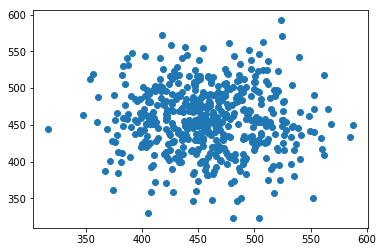

In [202]:
# plot x0 vs x1 (inputs) data
plt.scatter(feature_dict['feature0'], feature_dict['feature1'])
plt.show()


In [203]:
# 

In [204]:
### UTILITIES

def prime_factors(n):
    """Returns all the prime factors of a positive integer"""
    factors = []
    d = 2
    while n > 1:
        while n % d == 0:
            factors.append(d)
            n /= d
        d = d + 1
        if d*d > n:
            if n > 1: factors.append(n)
            break
    return factors

# examples
# pfs = prime_factors(1000)
# largest_prime_factor = max(pfs) # The largest element in the prime factor list

from functools import reduce

#examples
# reduce(lambda x, y: x*y, [1,2,3,4,5,6]) 

In [205]:
# get new data
new_data = generate_data(sample_size=200, number_of_features=12)
new_y_data = generate_response(new_data,coef=(21,-41,3,43,11,-17,5,-1.2,30,-61,32,0))

print('features: ', [load_individual_features(new_data)['feature'+str(i)][0] for i in range(new_data.shape[1])],
      ', response: ', new_y_data[0]) 

features:  [1673, 3719, 3203, 4005, 5575, 2005, 2805, 1769, 3634, 4300, 5332, 3687] , response:  [ 120376.03274777]


In [206]:
# understand regression along one dimension

def project_data(data, feature_dict=None, retained_feature_index = 0):
    """
    for given dataset, returns a projected dataset onto a single variable, with the other variables padded by mean value
    the purpose is for understanding the regression model on the single retained feature.
    indexing starts at 0
    """
    
    if feature_dict == None: 
        feature_dict=load_individual_features(data)
    
    sample_size , number_of_features = data.shape
    projected_data = np.zeros(shape=(sample_size,number_of_features)) #initialize
    
    means = {}
    for i in range(number_of_features):
        means['feature' + str(i) + 'mean'] = np.mean(feature_dict['feature' + str(i)])
            
    for i in range(sample_size):
        projected_data[i] = np.array(
            [means['feature' + str(j) + 'mean'] for j in range(retained_feature_index)] 
            + [data[i][retained_feature_index]]
            + [means['feature' + str(j) + 'mean'] for j in range(retained_feature_index+1,number_of_features)])
        
    return projected_data


In [207]:
### TEST BLOCK
project_onto_0 = project_data(data)
project_onto_1 = project_data(data, retained_feature_index=1)

print(project_onto_0[0:2], '\n'*2, project_onto_1[0:2])

[[ 402.55037536  456.60480788  457.35491001  459.07695041  454.9675226
   457.63780333  456.5614709   458.21300964  455.69943941  455.59636402
   458.79848676  457.58814817]
 [ 451.85009732  456.60480788  457.35491001  459.07695041  454.9675226
   457.63780333  456.5614709   458.21300964  455.69943941  455.59636402
   458.79848676  457.58814817]] 

 [[ 457.91738316  488.92139556  457.35491001  459.07695041  454.9675226
   457.63780333  456.5614709   458.21300964  455.69943941  455.59636402
   458.79848676  457.58814817]
 [ 457.91738316  511.80517401  457.35491001  459.07695041  454.9675226
   457.63780333  456.5614709   458.21300964  455.69943941  455.59636402
   458.79848676  457.58814817]]


In [208]:
# generate predictions on projected data
def generate_predictions(test_data, trained_model):
    """
    trained_model = (regression) model that has been fit to training data
    test data = for generating predictions
    returns a dictionary of the various projected data 
    and a dictionary of the various predictions for each projected dataset
    keys are:
        'data_projected_onto' + str(i)
        'predictions_along_projection' + str(i)
    
    TODO - modify so you can input a dictionary of already projected 'test datasets'
    """
    
    projected_data_dict = {}
    predictions_dict = {}
    
    sample_size , number_of_features = test_data.shape
    
    for i in range(number_of_features):
        projected_data_dict['data_projected_onto' + str(i)] = project_data(test_data, retained_feature_index=i)
        predictions_dict['predictions_along_projection' + str(i)] = trained_model.predict(projected_data_dict['data_projected_onto' + str(i)])
    
    return (projected_data_dict, predictions_dict)
    

In [209]:
### TEST BLOCK

# train model
lm = sklearn.linear_model.LinearRegression()
_ = lm.fit(data, response)

projected_datasets_dict, predictions_dict = generate_predictions(data, lm)
predictions_dict.keys()
print(predictions_dict['predictions_along_projection0'][0])
projected_datasets_dict['data_projected_onto0'][0:2]

[ 10372.53493364]


array([[ 402.55037536,  456.60480788,  457.35491001,  459.07695041,
         454.9675226 ,  457.63780333,  456.5614709 ,  458.21300964,
         455.69943941,  455.59636402,  458.79848676,  457.58814817],
       [ 451.85009732,  456.60480788,  457.35491001,  459.07695041,
         454.9675226 ,  457.63780333,  456.5614709 ,  458.21300964,
         455.69943941,  455.59636402,  458.79848676,  457.58814817]])

In [210]:
# simple automatted scatterplot of features against response
def response_scatterplot_matrix(data, feature_dict, response=None, desired_indices=None, dictionary_tuple=None):
    """
    simple automatted scatterplot of x_i and y
    
    uses load_individual_features method to get feature_dict
    could put that as an input if you already have it
    
    data = a numpy array of features with shape [sample_size , number_of_features]
    response = measured response var. right now has a default... should consider getting rid of that
    
    uses utilities 
        'prime_factors' 
        reduce from functools
        
    if dictionary_tuple is passed, it pulls projected_data_dict and predictions_dict
    from it and generates a scatterplot matrix with regression prediction lines plotted
    to obtain dictionary_tuple input, use the generate_predictions function.
    keys for projected_data_dict and predictions_dict are:
        'data_projected_onto' + str(i)
        'predictions_along_projection' + str(i)
    """
    
    # initialize necessary variables
    if response.any() == None: response=generate_response(data)
    if feature_dict == None: feature_dict=load_individual_features(data)
    if dictionary_tuple != None:
        _ , predictions_dict = dictionary_tuple
    sample_size , number_of_features = data.shape
    if desired_indices == None:
        desired_indices = list(range(sample_size)) #don't change list indices
    
    # get indices of interest
    plotted_indices = list(set(range(number_of_features)).intersection(list(desired_indices)))
    plotted_indices.sort #in place sorting ... no difference?

    # get plot dimensions
    pfs = prime_factors(len(plotted_indices))
    # cut the list of factors in half, with odds -> lower half gets one more term
    # since lower factors are smaller
    cutoff = int((len(pfs) + 1)/2) 
    if len(pfs) == 1: 
        pfs = [1] + pfs # if prime add in a dimension '1'#
        nrows = int( reduce(lambda x, y: x*y, pfs[0:cutoff]) )
        ncols = int( reduce(lambda x, y: x*y, pfs[cutoff:len(pfs)]) )
    else: 
        nrows = int( reduce(lambda x, y: x*y, pfs[0:cutoff]) )
        ncols = int( reduce(lambda x, y: x*y, pfs[cutoff:len(pfs)]) )

    # create plot array
    ###
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, sharey=True)#, sharex=True)
    plt.subplots_adjust(top=.9, bottom=.1, hspace=.5,wspace=.2) # tentative defaults, tested for n=12 plots
    ax=ax.flatten()    
    ###

    # fill in plot array
    
    # if you have data to plot a regression
    if dictionary_tuple != None: 
        for i in range(len(plotted_indices)):
            ax[i].scatter(feature_dict['feature'+str(plotted_indices[i])], response, s=.5)
            # ax[i].set_title('???' + str(i))
            ax[i].set_xlabel('x'+str(plotted_indices[i]))
            ax[i].set_ylabel('y') 
            ax[i].plot(feature_dict['feature'+str(plotted_indices[i])], predictions_dict['predictions_along_projection' + str(plotted_indices[i])], color='red', linewidth=.8)
            
    # generate a scatterplot
    else:
        for i in range(len(plotted_indices)): # needs to be sorted!
            ax[i].scatter(feature_dict['feature'+str(plotted_indices[i])], response, s=.5)
            # ax[i].set_title('???' + str(i))
            ax[i].set_xlabel('x'+str(plotted_indices[i]))
            ax[i].set_ylabel('y') 


    plt.show()
    

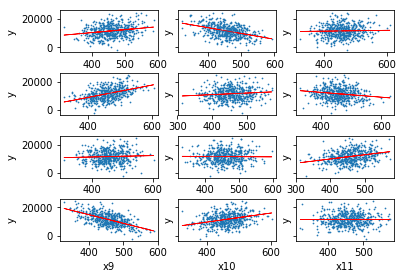

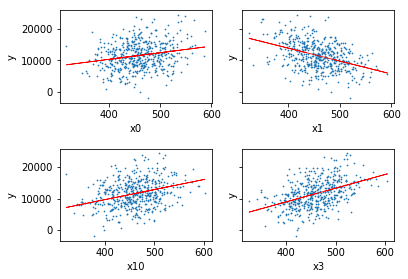

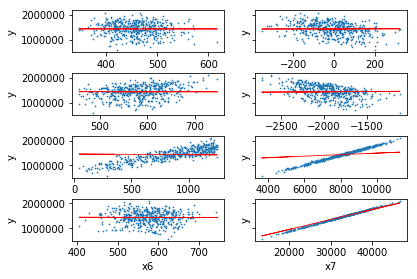

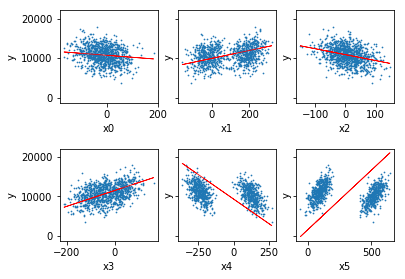

In [212]:
### TEST BLOCK
# response_scatterplot_matrix(data,response=data_y,feature_dict=feature_dict) # without regression
# response_scatterplot_matrix(data,response=data_y,feature_dict=feature_dict,desired_indices=(1,3,0,10)) # select only a few variables
response_scatterplot_matrix(data,response=response,feature_dict=feature_dict,
                            dictionary_tuple=generate_predictions(data, lm)) # with regression
response_scatterplot_matrix(data,response=response,feature_dict=feature_dict,
                            desired_indices=(1,3,0,10),dictionary_tuple=generate_predictions(data, lm)) # with regression

# mixed / covariance data 
mixed_data = generate_data(dist_type='covariance')
mixed_response = generate_response(mixed_data)
mixed_feature_dict = load_individual_features(mixed_data)

# train model
mixed_lm = sklearn.linear_model.LinearRegression()
_ = mixed_lm.fit(mixed_data, mixed_response)
response_scatterplot_matrix(mixed_data,response=mixed_response,
                            feature_dict=mixed_feature_dict,
#                             desired_indices=(1,3,0,5),
                            dictionary_tuple=generate_predictions(mixed_data, mixed_lm)) # with regression

# binormal data (generated as example in block 2)
binormal_response = generate_response(binormal_data)
binormal_feature_dict = load_individual_features(binormal_data)

# train model
binormal_lm = sklearn.linear_model.LinearRegression()
_ = binormal_lm.fit(binormal_data, binormal_response)
response_scatterplot_matrix(binormal_data,response=binormal_response,
                            feature_dict=binormal_feature_dict,
#                             desired_indices=(1,3,0,5),
                            dictionary_tuple=generate_predictions(binormal_data, binormal_lm)) # with regression



In [214]:
# generate scatterplot matrix of covariates / features
def features_scatterplot_matrix(data, features=None, diagonal='hist'):
    """
    method for generating simple scatterplot matrix for desired features
    data is a numpy array with shape (sample_size,number_of_features)
    defualt has default featuers = [0,1,...,number_of_features-1]
    diagonal argument is used for the scatter_matrix method from pandas.plotting:
        'kde' for kernel density estimation
        'hist' for histogram
    """
    
    if features==None: features = range(data.shape[1])
    
    df = pd.DataFrame(data[:, list(features)], columns = ['x' + str(i) for i in features])
    dim = min(int(1.5*len(features)), 18)
    scatter_matrix(df, alpha = 0.5, figsize = (dim,dim), diagonal = diagonal)
    plt.show()         
    

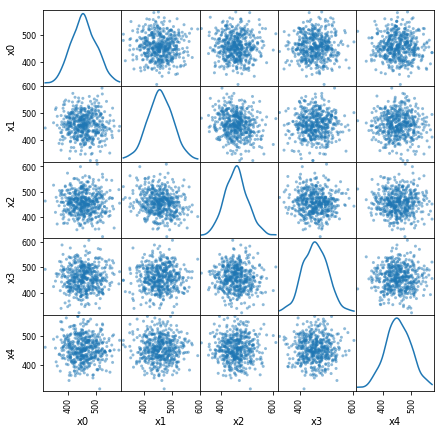

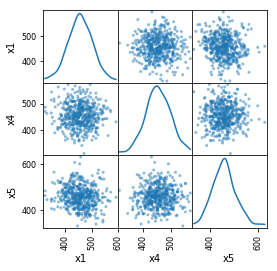

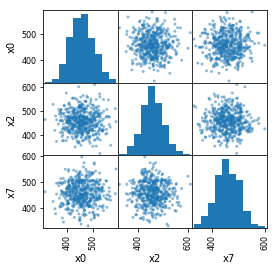

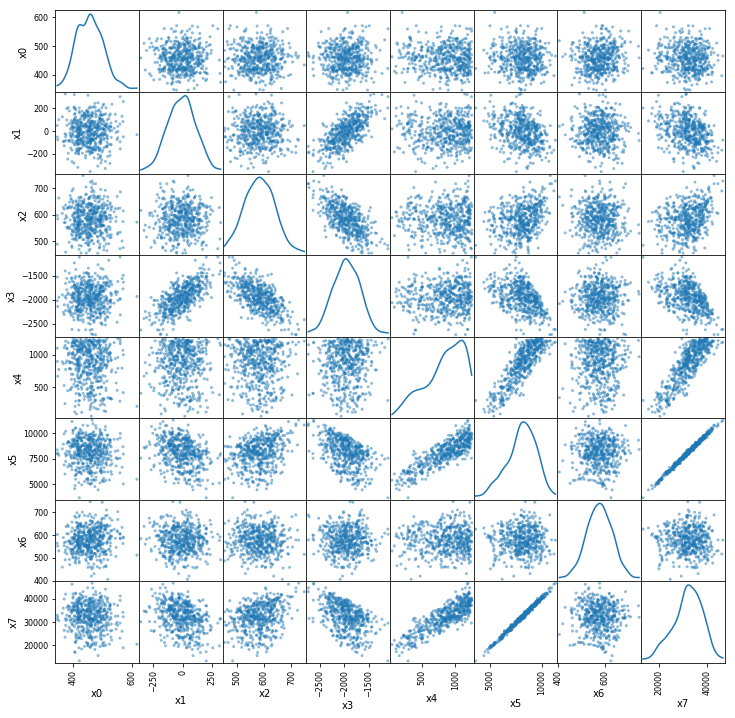

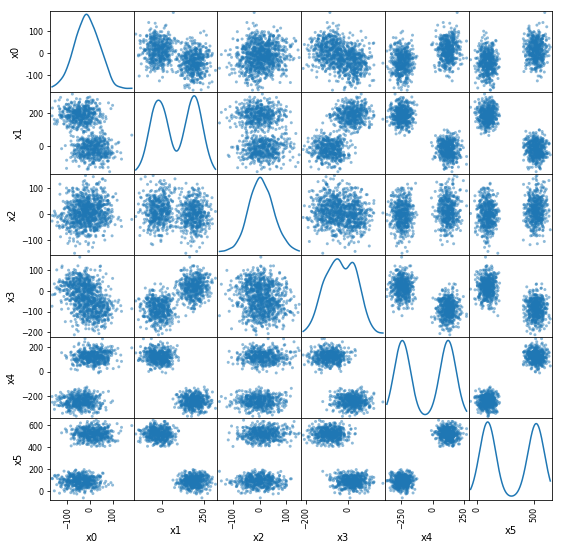

In [216]:
### TEST BLOCK
# scatterplot_matrix(data)
features_scatterplot_matrix(data,features=range(5),diagonal='kde')
features_scatterplot_matrix(data,features=(1,4,5),diagonal='kde')
features_scatterplot_matrix(data,features=(0,2,7),diagonal='hist')

features_scatterplot_matrix(mixed_data,diagonal='kde')
features_scatterplot_matrix(binormal_data,diagonal='kde')

In [58]:
# IMPLEMENTED
# ### TESTING IMPROVED RESPONSE SCATTERPLOT
# fig, ax = plt.subplots(ncols=3, nrows=4, sharey=True, sharex=True)
# # plt.subplots_adjust(top=1.5, bottom=0.15, left=0.15, right=1.5, hspace=0.5, wspace=1.5)
# plt.subplots_adjust(top=.9, bottom=.1, hspace=.5,wspace=.2) # tentative defaults, tested for n=12 plots

# # print(ax)
# ax=ax.flatten()
# # print(ax)

# for i in range(data.shape[1]): # needs to be sorted!
#     ax[i].scatter(feature_dict['feature'+str(i)], data_y, s=.5)
# #     ax[i].set_title('???' + str(i))
#     ax[i].set_xlabel('x'+str(i))
#     ax[i].set_ylabel('y')    
# plt.show()

In [59]:
# ##### OLD CODE

# # simple automatted scatterplot of features against response
# def response_scatterplot_matrix(data, data_y=generate_response(data), desired_indices=None, feature_dict=load_individual_features(data), dictionary_tuple=None):
#     """
#     simple automatted scatterplot of x_i and y
    
#     data = a numpy array of features with shape [sample_size , number_of_features]
#     data_y = measured response var. right now has a default... should consider getting rid of that
    
#     uses utilities 
#         'prime_factors' 
#         reduce from functools
#     if projected_data_dict and predictions_dict are passed in 
#     it generates a scatterplot matrix with regression prediction lines plotted
#     to obtain these, use generate_predictions function.
#     keys are:
#         'data_projected_onto' + str(i)
#         'predictions_along_projection' + str(i)
#     """
    
#     if dictionary_tuple != None:
#         _ , predictions_dict = dictionary_tuple
    
#     sample_size , number_of_features = data.shape
#     pfs = prime_factors(number_of_features)

#     nrows = reduce(lambda x, y: x*y, pfs[0:int(len(pfs)/2)+1]) 
#     ncols = reduce(lambda x, y: x*y, pfs[int(len(pfs)/2)+1:len(pfs)]) 

#     if desired_indices == None:
#         desired_indices = list(range(sample_size)) #don't change list indices
    
#     plotted_indices = set(range(number_of_features)).intersection(list(desired_indices))
    
#     # if you have data to plot a regression
#     if dictionary_tuple != None: 
#         for i in plotted_indices:
#             plt.subplot(nrows, ncols, i+1)
            
# #             single_feature_data = [x[i] for x in projected_datasets_dict['data_projected_onto' + str(i)]]
# #             single_feature_data = [x[i] for x in data]
    
#             plt.scatter(feature_dict['feature'+str(i)], data_y, s=.5)   
#             plt.plot(feature_dict['feature'+str(i)], predictions_dict['predictions_along_projection' + str(i)], color='red', linewidth=.8)
            
# #             plt.scatter(single_feature_data, data_y, s=.5)   
# #             plt.plot(single_feature_data, predictions_dict['predictions_along_projection' + str(i)], color='red', linewidth=.8)
#     # generate a scatterplot
#     else:
#         for i in plotted_indices: # needs to be sorted!
#             plt.subplot(nrows, ncols, i+1)
#             plt.scatter(feature_dict['feature'+str(i)], data_y, s=.5)
# #             plt.set_xlabel('x'+str(i))
# #             plt.set_ylabel('y')


#     plt.show()
    
# # #     plt.text(0.5, 0.5, str((2, 3, i)),
# # #              fontsize=18, ha='center')
# # plt.show()

# ### TEST BLOCK
# response_scatterplot_matrix(data,data_y=data_y,feature_dict=feature_dict) # without regression
# response_scatterplot_matrix(data,data_y=data_y,feature_dict=feature_dict,desired_indices=(1,2)) # select only a few variables
# response_scatterplot_matrix(data,data_y=data_y,feature_dict=feature_dict,
#                             dictionary_tuple=generate_predictions(data, lm)) # with regression
# response_scatterplot_matrix(data,data_y=data_y,feature_dict=feature_dict,
#                             desired_indices=(1,2),dictionary_tuple=generate_predictions(data, lm)) # with regression





input: [ 451.50424673  405.84617416  479.70320713  446.17363051  414.93562187
  482.53780667] 
response: [ 8112.60475279]


Scatterplot Matrix of Covariates


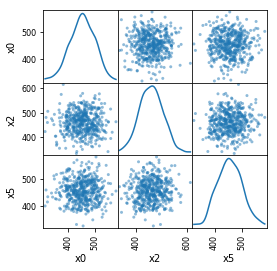

Selected Feature/Response Scatterplot Matrix


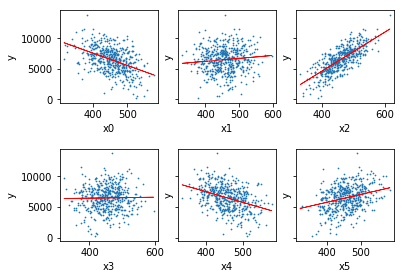

In [60]:
### TEST BLOCK

# generate multivariable data
data = generate_data(dist_type='normal')
feature_dict = load_individual_features(data)
response = generate_response(data, feature_dict, coef=(-20,5,32,1,-17, 13))
print('input:', data[0], '\n'+'response:', response[0], end='\n'*3)

# train a linear model
lm = sklearn.linear_model.LinearRegression()
_ = lm.fit(data, response)

#plots
print('Scatterplot Matrix of Covariates')
features_scatterplot_matrix(data,features=(0,2,5),diagonal='kde')
print('Selected Feature/Response Scatterplot Matrix')
response_scatterplot_matrix(data,response=response,feature_dict=feature_dict,
                            # select features
                            #desired_indices=(1,2),
                            # plot regression
                            dictionary_tuple=generate_predictions(data, lm))
